# Basics of Parameter Estimation

This Notebook aims to introduce the basics of parameter estimation 
using "fits" with [`zfit`](https://github.com/zfit/zfit). 
We also use [`numpy`](https://numpy.org/) for data managment and generation. 
It is inspired among others by the great [tutorial from Hans at pyHEP](https://nbviewer.org/github/HDembinski/PyHEP-2022-iminuit/blob/main/iminuit.ipynb) and i want to thank **Jonas Eschle** for the help in the preparation of this tutorial as well as all the work on `zfit`. 

## What zfit can do:

 - **Parameter estimation**, through minimisation of statistical cost functions
   - Binned and unbinned cost functions
   - Extended and not extended cost functions
   - Minimisation handled by [`(i)Minuit`](https://iminuit.readthedocs.io/en/stable/)
 - **Uncertainty estimation** of those parameters
 - Build complex **statistical models** to describe your data
 - Handle simple or more complex **parameter constraints**
 - **Sample** from the statistical models
 
## What zfit does not do
 
  - Visualise the fit or the data
  - Limit setting or other statistical methods
  - Data preparation or selection
  
"Divide and Conquer", zfit aims to perform the operations described above and cooperate well with other libraries
that perform other operations, such as `numpy`, [`matplotlib`](https://matplotlib.org/), and [`uproot`](https://github.com/scikit-hep/uproot5).

## Today

Hands on examples on:
 - How to run a simple fit
 - Visualise the fit
 - Explore why a fit may fail
 - Statistical background subtraction using the [$_{s}\mathcal{P}lot$ technique](https://arxiv.org/pdf/physics/0402083.pdf)
 - Simultaneous fitting to multiple datasets
 - Constraining parameters in the fit

In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
# numpy is used for generating, storing, and plotting data
import numpy as np
# zfit will be used for the parameter estimation in the following
import zfit
# in order to visualise the results of the computation, we use matplotlib
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc') # some plotting presets i usually use, you can find them in the git-repo
import matplotlib.pyplot as plt
# for histograms boost has an easy api and is very fast
import boost_histogram as bh
# for statistical distributions we can use a lot from scipy
from scipy import stats

2022-11-15 12:48:07.955279: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup

We will start by generating some data using `numpy` that follow a normal distribution. 

In [2]:
# create a sample with size 3000 that follow a normal distribution
gen = np.random.default_rng(seed=1337)
data = gen.normal(0, 1, size=(3000,))
print(f'Mean: {data.mean():.3f} Standard Dev.: {data.std(ddof=1):.3f}')

Mean: -0.006 Standard Dev.: 1.002


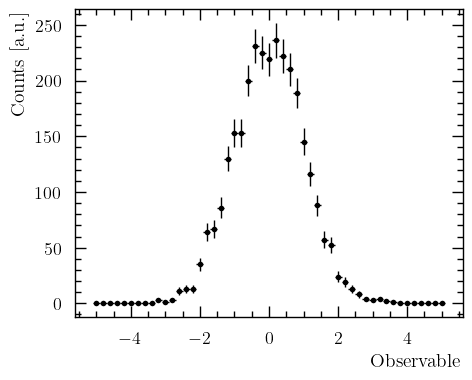

In [3]:
# visualise the data using a histogram:
fig, ax = plt.subplots()
# histogram with centered bins
hist = bh.Histogram(bh.axis.Regular(51, -5.1, 5.1))
hist.fill(data)
# errorbar histogram for the data
ax.errorbar(hist.axes.centers[0], hist.values(), xerr=hist.axes.widths[0]/2,
           yerr=np.sqrt(hist.values()), fmt='.', label='Data', color='black')
# labels
ax.set_xlabel('Observable')
ax.set_ylabel('Counts [a.u.]');

As we can see, the data seem to follow a normal distribution. 
If we want to determine the an estimate for the centre and width of the distributions we can either compute them as we did above through the arithmetic mean and empirical standard deviation or we may run a fit. 

## Fitting

For the fit we need:
 - An observable space
 - Data that is compatible with zfit
 - A model that describes the data
 - Parameters that control the model shape
 - The statistical cost function
 - A minimizer to optimise our cost function
 
Check the [documentation](https://zfit.readthedocs.io/en/latest/user_api/index.html) if youre unsure about arguments!

In [5]:
# observable space
obs = zfit.Space('Observable', limits=(-5, 5))

# data in zfit
data_zfit = zfit.Data.from_numpy(obs=obs, array=data)
# note that zfit will crop the array given the limits of obs!

# model and parameters
mu = zfit.Parameter("mu", data.mean(), -1, 1)
sigma = zfit.Parameter("sigma", data.std(ddof=1), 0.1, 2)
model = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, name='gaussian_model')

2022-11-15 12:59:05.206760: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Cost Functions

There are different objectives, called cost functions in statistics, that may 
be optimised when trying to infer parameters from collected data. 
In physics, the most prominent objectives are motivated from the `Maximum Likelihood` (ML)
or the `Least Squares` (LS, also known as $\chi^2$) paradigms. 
For further reading on this i recommend one of the many great statistics books,
for example [Statistical Data Analysis](https://www.amazon.com/-/en/Glen-Cowan/dp/0198501552) by Glen Cowan. 

We want to focus on hands on examples for two types of ML fits today: `binned` and `unbinned` fits. 
Conceptually they differ in the way that the data are treated, 
as the name suggests the binned fits take a histogram representation of the data 
whereas the unbinned fits consider the "raw" data as input. 

Note: In machine learning the cost functions are often called `loss`. 

In [6]:
# the cost function
nll_unbinned = zfit.loss.UnbinnedNLL(model=model, data=data_zfit)

# the minimiser
minimiser = zfit.minimize.Minuit(mode=1)

## Running the fit

We can run the minimisation of the cost function by calling `minimize` of the minimizer with the cost as argument. 
This calls the `migrad` algorithm of `Minuit`, which is a very robust and performant minimization algorithm. 

The `mode` option controls the minimization strategy used internally by `Minuit`, see [their docs](https://iminuit.readthedocs.io/en/stable/faq.html#what-happens-when-i-change-the-strategy). As a rule of thumb:
 - 0: The fastest fitting strategy. Scales linearly with number of parameters. Should be used for fits with high numbers of parameters. 
 - 1: The **default** strategy. Scales quadratically with number of parameters. More accurate determination of the second derivatives, therefore slower. 
 - 2: Scales quadratically with number of parameters. Slower than 1 because accurate hessian is computed at each step. 

In [12]:
# run the fit:
result = minimiser.minimize(nll_unbinned)
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Data object at 0x7fad576ec5e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.7e-12 │ 999.9999    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu             -0.00583433       False
sigma               1.0017       False

## Visualising the Result

Lets start by defining a function to visualise the fit. 

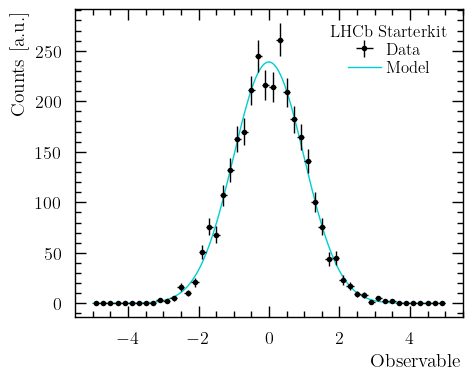

In [11]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=50, smodel: np.ndarray=None,
             drawstyle: str='default'):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    hist = bh.Histogram(bh.axis.Regular(nbins, *limits))
    hist.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(hist.axes.centers[0], hist.values(), 
                           xerr=hist.axes.widths[0]/2,
                           yerr=np.sqrt(hist.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)
        
    # legend and axis labels
    ax.legend((art_data, art_model), ('Data', 'Model'), loc='best', 
              title='LHCb Starterkit', title_fontsize=12)
    ax.set_xlabel('Observable')
    ax.set_ylabel('Counts [a.u.]');
    
basis = np.linspace(-5, 5, 200)
model_np = model.pdf(basis).numpy() * data.shape[0]
plot_fit(data, basis, model_np, obs)

The fit looks good by eye, but lets inspect the fit result more closely:

In [13]:
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Data object at 0x7fad576ec5e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.7e-12 │ 999.9999    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu             -0.00583433       False
sigma               1.0017       False

## Digesting the Result

We have performed our first fit! The results are compatible with the mean and standard dev. we computed above!
zfit tells us:
 - The parameter names and their value at the minimum
 - Validity of the minimum (see Minuit documentation for this)
 - Convergence status
 - If parameters have hit boundaries
 - The EDM (estimated distance to minimum) 
 - The cost function value at the minimum

We can get even more information by inspecting the `info` of the result:

In [14]:
print(f'These keys are available: {result.info.keys()}')
print(f'Number of evaluations: {result.info["n_eval"]}')
print(f'Inverse hessian matrix: ')
print(result.info['inv_hessian'])
result.info['minuit']

These keys are available: dict_keys(['n_eval', 'minuit', 'original', 'inv_hessian'])
Number of evaluations: 26
Inverse hessian matrix: 
[[3.34471915e-04 2.09122894e-08]
 [2.09122894e-08 1.67266903e-04]]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1000                       │              Nfcn = 26               │
│ EDM = 1.69e-12 (Goal: 0.001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  -0.006   │   0.018   │            │            │   -1    │    1    │       │
│ 1 │ sigma │   1.002   │   0.013   │            │            │   0.1   │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000334 2.09e-08 │
│ sigma │ 2.09e-08 0.000167 │
└───────┴───────────────────┘

In jupyter notebooks, the `Minuit` object is rendered nicely, we see:
 - FCN, the cost function value at the minimum
 - EDM, the estimated distance to minimum (must be smaller than Goal for valid minimum)
 - Nfcn, the number of function calls 
 - Validity of the found minimum
 - If parameters have hit a boundary
 - The status of the covariance matrix: accurate and positive definite, without being forced. (must be this for valid minimum)

There is more information regarding the parameters in the view from minuit:
 - Name of the parameter
 - Value at the minimum (rounded with PDG rounding rules)
 - Hesse Error, the standard symmetric uncertainty estimate (computed during minimisation in `migrad`)
 - Minos Error, the asymmetric uncertainty estimate based on likelihood profiling
 - The covariance matrix of the parameters

## Uncertainties

In order to determine the uncertainties at the best fit point, we can run the hesse algorithm again: 

In [15]:
errs = result.hesse(name='minuit_hesse')
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Data object at 0x7fad576ec5e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.7e-12 │ 999.9999    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)    minuit_hesse    at limit
------  ------------------  --------------  ----------
mu             -0.00583433     +/-   0.018       False
sigma               1.0017     +/-   0.013       False

Now we also have the uncertainties from `hesse` in the zfit parameter view. 

In order to access the parameter values and uncertainties we can use the `params` object from the `result`. 
Here we find for all our parameters the 'value', and uncertainty information. 
The uncertainty field is saved under the method name (in our case `minuit_hesse`) that was given to the hesse call: 

In [16]:
pars = result.params
print(f'Keys of pars: {[k for k in pars.keys()]}')
print(f'Parameter mu: {pars["mu"]["value"]:.4f} +/- {pars["mu"]["minuit_hesse"]["error"]:.4f}')
print(f'Parameter sigma: {pars["sigma"]["value"]:.4f} +/- {pars["sigma"]["minuit_hesse"]["error"]:.4f}')

Keys of pars: [<zfit.Parameter 'mu' floating=True value=-0.005834>, <zfit.Parameter 'sigma' floating=True value=1.002>]
Parameter mu: -0.0058 +/- 0.0183
Parameter sigma: 1.0017 +/- 0.0129


Asymmetric uncertainties on parameters can be determined using `minos`, which is based on likelihood profiling 

In [17]:
errs_minos = result.errors(method='minuit_minos', name='minuit_minos')
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.core.data.Data object at 0x7fad576ec5e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.7e-12 │ 999.9999    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)    minuit_hesse         minuit_minos    at limit
------  ------------------  --------------  -------------------  ----------
mu             -0.00583433     +/-   0.018  -  0.018   +  0.018       False
sigma               1.0017     +/-   0.013  -  0.013   +  0.013       False

In this case the symmetric and asymmetric uncertainties yield the same results. This is because the asymptotic theory is correct in this case. 

Generally LHCb statistics guidelines prefer to report symmetric uncertainties for quantities unless the uncertainties obtained through minos are very asymmetric. 

## Visualising the Cost

`Minuit` offers a quick way to draw the cost function depending on the parameter in question:

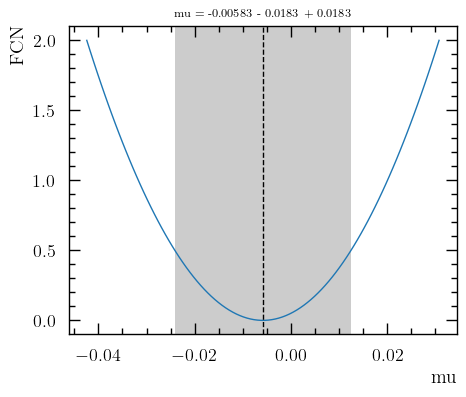

In [18]:
minimiser._minuit_minimizer.draw_profile('mu');

This is now a simple profile of the cost when varying the parameter in question. 
The gray region visualises the $68\,\%$ confidence regions. 


Generally this does **not** coincide with the uncertainties quoted by `hesse` or `minos`, because correlations alter the picture. For correct coverage, at each point the cost needs to be minimised with respect to the nuisance parameters (all other parameters that arent fixed) in order to obtain the correct profile. 

Also for this `Minuit` offers a quick way to draw the correct contour. This is only possible after having run `minos` and is computationally more expensive: 

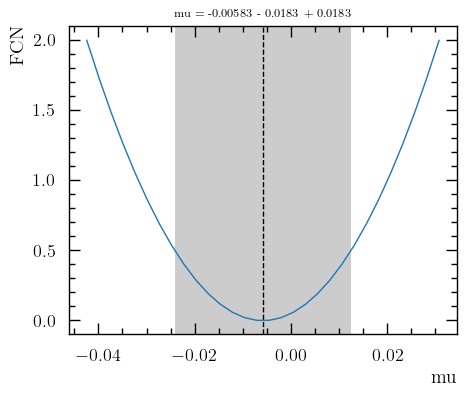

In [19]:
minimiser._minuit_minimizer.draw_mnprofile('mu');

Also two dimensional profiles of the likelihood are quickly draw-able with `Minuit` using. 
Note the small correlations in our fit to the normal distribution. 

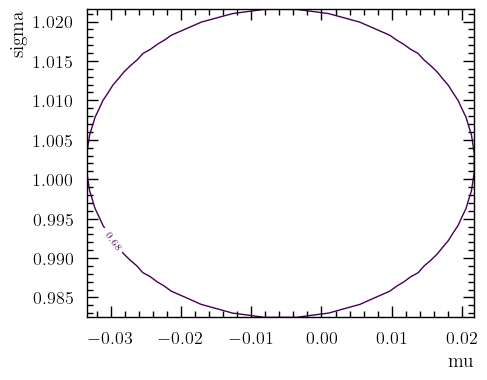

In [20]:
minimiser._minuit_minimizer.draw_mncontour('mu', 'sigma');

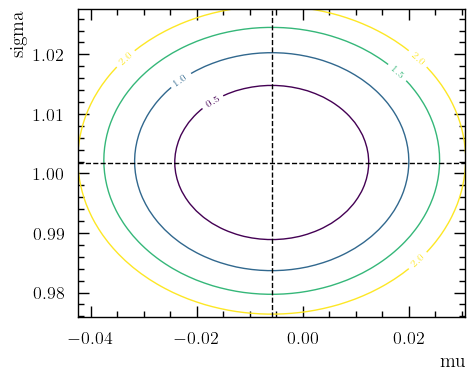

In [21]:
minimiser._minuit_minimizer.draw_contour('mu', 'sigma');

## Visualising the Uncertainties

One can propagate the uncertainties on the individual parameters to the lineshape of the model in the visualisation. 
For this we cannot simply "shift" all parameters according to their uncertainties as this would again not reflect on correlations of the parameters. 

Instead we need to **correctly propagate** the uncertainties to the lineshape. This is possible in multiple ways and i will show you the **bootstrapping** approach. For this we sample random numbers from the multivariate normal distribution that we obtained from the fitter and evaluate the model for each random sample. 
The uncertainty on the model at each point is then given by the empirical standard deviation of the ensemble of models:

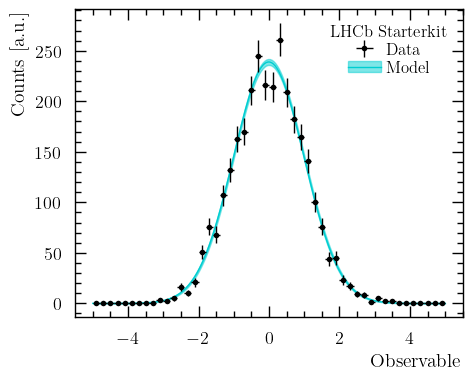

In [22]:
# get the vector of means for the mv. gaussian and the covariance
mean_params = [result.params[p]['value'] for p in result.params.keys()]
covariance = result.covariance()
# generate the random combinations of mu and sigma 
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)

# evaluate the model at each point of the basis for all parameters that were previously sampled
# then take the standard deviation along the basis axis for all elements in the 2-D array
# Note: List comprehension may look hacky at times but its fast!
smodels_np = np.std([stats.norm.pdf(basis, loc=_mu, scale=_sigma) * data.shape[0] 
                     for _mu, _sigma in rnd_pars], ddof=1, axis=0)

# visualise the uncertainty:
plot_fit(data, basis, model_np, obs, smodel=smodels_np)

## Binned Fits

It is also possible to fit binned datasets in zfit. For this we need:
 - Create a binned space
 - Create a binned dataset
 - Create a binned model
 - Create a binned loss
 - Run the minimisation

In [ ]:
# Binned space needs to have binning information
obs_binned = zfit.Space('Observable', limits=(-5, 5), binning=50)

# we can create a binned dataset from the unbinned one by specifying the space
data_zfit_binned = data_zfit.to_binned(obs_binned)

# binned model from our unbinned model
model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

# binned likelihood cost function
nll_binned = zfit.loss.BinnedNLL(model_binned, data_zfit_binned)

# run the minimisation
result_binned = minimiser.minimize(nll_binned)

# perform uncertainty determination
result_binned.hesse(name='minuit_hesse')
result_binned.errors(method='minuit_minos', name='minuit_minos')
result_binned

## Differences of Binned and Unbinned Fits

There are some small differences between the binned and the unbinned fits. This is mainly motivated by the different (less) information that the binned fit can access compared to the unbinned one. The more bins a binned fit uses, the closer the fit result of the unbinned and binned fits usually become. 

In [ ]:
print('Results from unbinned fit: ')
print([result.params[p]['value'] for p in result.params.keys()])
print('Results from binned fit: ')
print([result_binned.params[p]['value'] for p in result_binned.params.keys()])

In [ ]:
basis_binned = model_binned.axes.centers[0]
model_np_binned = model_binned.values().numpy() * data.shape[0] / obs_binned.area() * 50

# steps-mid yields the usual histogram draw style
plot_fit(data, basis_binned, model_np_binned, obs_binned, drawstyle='steps-mid')

## Composite Models

In real life, usually the data we deal with is not described by a "simple" gaussian but also features some backgrounds that pollute the data in the signal region. 
In the case that one can make assumptions about the shape of the background distribution we can fit the combined background and signal shape to the data. 

In `zfit` this functionality is implemented by the ability to "add" up different models. It can be done with fractions of the respective model with respect to all or with extended models. Extended models are models that have a "yield" associated to them. 

In [ ]:
# background from exponential + gaussian for signal
data_gauss = gen.normal(0.5, 0.1, size=(3000,))
data_exp = gen.exponential(0.4, size=(5000,))
data_all = np.append(data_gauss, data_exp)

# new observable and zfit data
obs_bkg = zfit.Space('Observable with Background', limits=(0, 1))
data_zfit = zfit.Data.from_numpy(obs=obs_bkg, array=data_all)

# parameters for signal and background shapes
mu_signal = zfit.Parameter('mu_signal', 0.5, 0.2, 0.8)
sigma_signal = zfit.Parameter('sigma_signal', 0.1, 1e-4, 1)

# be careful and check the documentation. numpy and in zfit there are
# different definitions of the slope parameter in use! 
# numpy: exp(-x/slope) zfit: exp(slope*x)
slope_bkg = zfit.Parameter('slope_bkg', -0.4e-1, -10, 0.1)

# yields for an extended fit
n_signal = zfit.Parameter('n_signal', 3000, 0, None)
n_bkg = zfit.Parameter('n_bkg', data_zfit.n_events.numpy()-3000, 0, None)

# create the pdfs with the extended term for the yields
gaussian = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_signal, sigma=sigma_signal, name='Signal')
gaussian_ext = gaussian.create_extended(n_signal)

exponential = zfit.pdf.Exponential(obs=obs_bkg, lam=slope_bkg, name='Background')
exponential_ext = exponential.create_extended(n_bkg)

# build the model as the sum of the gaussian and the exponential functions
model = zfit.pdf.SumPDF([gaussian_ext, exponential_ext])

# loss function is now extended unbinned NLL
nll_ext = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

result_ext = minimiser.minimize(nll_ext)
result_ext

In [ ]:
# visualise as we have discussed before
# with the addition of this helper function for the uncertainties
def eval_zfit_model(model: zfit.pdf.BasePDF, basis:np.ndarray, pars: np.ndarray)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    ns, nb, mu, sig, lam = pars
    mu_signal.set_value(mu)
    sigma_signal.set_value(sig)
    slope_bkg.set_value(lam)
    return model.pdf(basis) * (ns+nb)

# the model as the sum of the individual pdfs
basis_pdf = np.linspace(0, 1, 200)
model_pdf_np = model.pdf(basis_pdf).numpy() * (n_signal.numpy()+n_bkg.numpy())

# the uncertainty computation on our model given the parameters
mean_params = [result_ext.params[p]['value'] for p in result_ext.params.keys()]
covariance = result_ext.covariance()
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)
smodel_pdf_np = np.std([eval_zfit_model(model, basis_pdf, pars) for pars in rnd_pars], ddof=1, axis=0)

# plotting all together
plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, smodel=smodel_pdf_np)

What we have done so far:
 - Perform fit to dataset (binned, unbinned, and extended)
 - Understand the result of the fit
 - Visualised fits with uncertainties
 - Visualised cost function dependence on parameters

The next part focuses on why a fit may fail but now lets head to the..
# Coffee-Break